# Risk Management III: Portfolio Allocation

Suppose an investor has a fixed amount of capital ($W$) to invest in stocks: how should one build a portfolio? So long as the individual assets are not perfectly correlated, there will be diversification benefits to holding them together as whilst some of them zig others will zag. 

Lets consider a portfolio that we wish to hold for one week (5 market days) and a selection of $n$ possible assets, each with a return over this period of $r_i$ - these are random variables. We wish to determine the fraction of capital that one should invest in each asset, $x_i$. The random variable, $R$, representing the return of the entire portfolio, is then:

$R = \boldsymbol{x^Tr}$  $\quad$ subject to $\quad$ $\boldsymbol{x^T1}=1$

where bolded variables are the equivalent column vector quantities and the constraint insists that we don't invest more than $W$.

## Mean-Variance Optimisation

We assume that the returns of each asset are stationary, in that their statistical properties are invariant of time. If the expected return of each asset is $\mu_i$ then the expected return of the portfolio is $\text{E}(R) = \boldsymbol{x^T\mu}$.

A rational investor is one that wishes to target a particular desirable outcome whilst incurring minimal risk. Markowitz described a mathematical framework now referred to as Modern Portfolio Theory, see [[1](https://www.math.ust.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf)]. He suggested modelling the desirable outcome as the expected return and the risk as the variance of returns: a mean-variance portfolio. For a given desired mean, $\mu^*$, this reduces to the following optimisation problem:

$\displaystyle{\min_{\boldsymbol{x}} \boldsymbol{x^T\Sigma x}}$   $\quad$ subject to     $\quad$ $\boldsymbol{x^T\mu} = \mu^*$, $\,\,$$\boldsymbol{x^T1}=1$.

where $\Sigma_{i,j} = \text{Cov}(r_i,r_j)$ is the covariance matrix of returns. An analytic solution can be found by forming and optimising a Lagrangian functional:

$L(\boldsymbol{x}, \lambda_1, \lambda_2) = \boldsymbol{x^T\Sigma x} + \lambda_1(\boldsymbol{x^T\mu} - \mu^*) + \lambda_2(\boldsymbol{x^T1} - 1)$

[E1]$\quad$ $\frac{\partial L}{\partial \boldsymbol{x}} = 2\boldsymbol{\Sigma x} + \lambda_1\boldsymbol{\mu} + \lambda_2\boldsymbol{1} = 0$

[E2]$\quad$ $\frac{\partial L}{\partial \lambda_1} = \boldsymbol{x^T\mu} - \mu^* = 0$

[E3]$\quad$ $\frac{\partial L}{\partial \lambda_2} = \boldsymbol{x^T1} - 1 = 0$

[E1] can be rearranged to give:

[E4]$\quad$ $\boldsymbol{x} = -\frac{1}{2}\lambda_1 \boldsymbol{\Sigma^{-1}\mu} - \frac{1}{2}\lambda_2 \boldsymbol{\Sigma^{-1}1} = -\frac{1}{2}\boldsymbol{\Sigma^{-1}\text{M}\lambda}$

where the $n\times2$ matrix $\boldsymbol{\text{M}} = [\boldsymbol{\mu:1}]$ and the $2\times1$ column vector $\boldsymbol{\lambda} = (\lambda_1, \lambda_2)^T$.

One can combine [E4] and [E2] to give:

[E5]$\quad$ $\mu^* = -\frac{1}{2}\lambda_1 \boldsymbol{\mu^T\Sigma^{-1}\mu} - \frac{1}{2}\lambda_2 \boldsymbol{\mu^T\Sigma^{-1}1}$

Similarly [E4] and [E3] can be combined to give:

[E6]$\quad$ $1 = -\frac{1}{2}\lambda_1 \boldsymbol{1^T\Sigma^{-1}\mu} - \frac{1}{2}\lambda_2 \boldsymbol{1^T\Sigma^{-1}1}$

[E5] and [E6] can be combined to give:

$\boldsymbol{\widetilde{\mu}} = -\frac{1}{2}\boldsymbol{\text{M}^T\Sigma^{-1}\text{M}\lambda} \implies \boldsymbol{\lambda} = -2(\boldsymbol{\text{M}^T\Sigma^{-1}\text{M}})^{-1}\boldsymbol{\widetilde{\mu}} $

where the $2\times1$ column vector $\boldsymbol{\widetilde{\mu}} = (\mu^*, 1)^T$. Thus, finally:

$\boldsymbol{x} = \boldsymbol{\Sigma^{-1}\text{M}(\text{M}^T\Sigma^{-1}\text{M})^{-1}\widetilde{\mu}}$

Below we consider four stocks: Apple (AAPL), IBM, Microsoft (MSFT) and Walmart (WMT). The data was obtained from Quandl.com, but their API could be used to programmatically rebalance a portfolio in light of new market data. We split three years of data into 150 week-long periods and calculate the logarithmic return over each to build up a distribution - treating each of these periods as independent. The function PlotEfficientFrontier() then uses the result above to calculate the minimum portfolio variance for 100 target means ($\mu^*$) in the range [-1, 1].

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import math

four_symbols = ["AAPL", "IBM", "MSFT", "WMT"]

def import_data( symbols ):

    cols = list(symbols)
    
    symbol = cols[0]
    path = symbol + ".csv"
    dates = pd.read_csv(path, index_col = 'Date', parse_dates = True).index   
    market_data = pd.DataFrame( np.zeros((len(dates), len(cols))) , columns = cols)
        
    for symbol in cols:
        path = symbol + ".csv"
        market_data[symbol] = pd.read_csv(path)["Adj_Close"]
        
    return market_data

def portfolio_returns( symbols ):
    
    market_data = import_data( symbols )    
    num_rows = len( market_data.index )
    days = 5
    num_simulations = int( np.floor( num_rows / days ) )
    portfolio_returns = []
    
    for i in range(num_simulations):
        log_returns = np.log(market_data.iloc[i + days - 1]/market_data.iloc[i])
        portfolio_returns.append(log_returns)
        
    return pd.DataFrame( portfolio_returns )

def OptimalPortfolio(n, mu, sigma_inv, target_mean):
    
    one = np.matrix(np.ones((n, 1)))
    mu_tilde = np.matrix([target_mean, 1]).T
    
    M = np.concatenate((mu, one), axis=1)
    
    C = M.T * sigma_inv * M
    
    C_inv = np.linalg.inv(C)
    
    optimal_x = sigma_inv * M * C_inv * mu_tilde
    
    return optimal_x

def OptimalVariances(target_means):
    
    n = len(four_symbols)
    returns_data = portfolio_returns( four_symbols )
    mu = np.matrix( returns_data.mean() ).T
    sigma = np.matrix( returns_data.cov() )
    sigma_inv = np.linalg.inv(sigma)
    optimal_vars = []
    
    for target_mean in target_means:
        optimal_x = OptimalPortfolio(n, mu, sigma_inv, target_mean)
        optimal_var = (optimal_x.T * sigma * optimal_x).tolist()[0][0]
        optimal_vars.append(optimal_var)

    return optimal_vars

def PlotEfficientFrontier():
    
    min_mean = -1
    max_mean = 1
    num_means = 100
    target_means = np.linspace(min_mean, max_mean, num_means)
    
    optimal_vars = OptimalVariances(target_means)
        
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    ax.set_title("\n".join(wrap("A graph showing optimal portfolio expected log returns as a function of variance for a 5 day holding period", 100)))
    ax.set_xlabel('Variance')
    ax.set_ylabel('Expected Logarithmic Return')
    plt.plot(optimal_vars, target_means)
    plt.show()


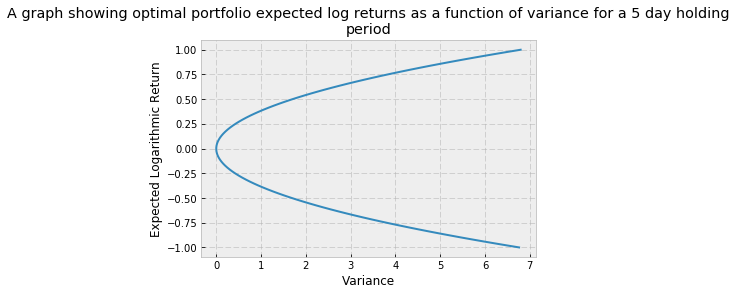

In [8]:
PlotEfficientFrontier()

This optimal boundary in risk-return space is called the *Efficient Frontier*. It is a hyperbola, although the bottom branch is a mathematical artefact. This is clear if one considers the dual optimisation problem: maximising the expected return for a given target variance level. Clearly no rational investor would select from the bottom branch. Whilst being mathematically equivalent, this approach is more difficult in practise since investors prefer to specify target return levels rather than target risk levels.

The function PlotPortfolioSimulations() below simulates 10,000 portfolios and plots them in risk-return space. For each simulation it selects a random portfolio allocation, $\{x_i\}$, and calculates the expected return and variance. The plot highlights the feasible region as inside the efficient frontier and confirms our optimal solution.

In [34]:
def RandomPortfolio(mu, sigma):
    
    # create random weights
    x = np.random.uniform(low=-1, high=1, size=(len(mu), 1))
    x = x/x.sum()
    x = np.matrix( x )
    
    ret = (x.T * mu).tolist()[0][0]
    variance = (x.T * sigma * x).tolist()[0][0]
    
    return [ret, variance]

def PlotPortfolioSimulations():
    
    num_simulations = 10000
    returns = []
    variances = []
    
    min_mean = -0.03
    max_mean = 0.03
    num_means = 100
    target_means = np.linspace(min_mean, max_mean, num_means)
    
    returns_data = portfolio_returns( four_symbols )
    mu = np.matrix( returns_data.mean() ).T
    sigma = np.matrix( returns_data.cov() )
    
    for i in range(num_simulations):
        
        ret, variance = RandomPortfolio(mu, sigma)
    
        returns.append( ret )
        variances.append( variance )
    
    optimal_variances = OptimalVariances(target_means)
    
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    
    ax.set_title("\n".join(wrap("A graph showing {} simulated expected log returns as a function of variance for a 5 day holding period".format(num_simulations), 100)))
    ax.set_xlabel('Variance')
    ax.set_ylabel('Expected Logarithmic Return')
    ax.set_xlim([0.0003,0.005])
    ax.set_ylim([min_mean,max_mean])
    plt.plot(variances, returns, 'o')  
    plt.plot(optimal_variances, target_means)
    plt.show()

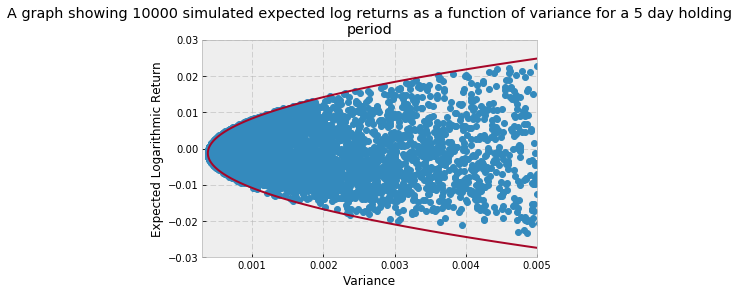

In [35]:
PlotPortfolioSimulations()

## Sharpe Ratio

Not long after Markowitz laid the foundations for Modern Portfolio Theory, William Sharpe invented a metric for comparing all of these different possible portfolios. First he acknowledged that in the presence of some risk-free asset investors focus on the *excess return* of a risky asset. This is what they can expect to receive over and above the risk free rate, $r_f$, which they can invest in whilst effectively taking on no risk.

The Sharpe ratio of a portfolio is the amount of excess return one can expect to achieve per unit of risk, measured as the standard deviation of returns:

$S = \frac{E(R - r_f)}{\sqrt{Var(R - r_f)}}$

Sharpe reasoned that a rational investor should want to maximise this ratio.

The function PlotSharpePortfolioSimulations() below calculates and visualises the Sharpe ratio of 100,000 simulated portfolios. We assume an annual risk-free rate of 2% and de-annualise this, assuming 252 trading days in the year, in order to compare it to our portfolio returns. This seemed to introduce fewer assumptions than if we had annualised the portfolio returns and variance - see [[2](https://www.researchgate.net/publication/228139699_The_Statistics_of_Sharpe_Ratios)] for a discussion on this.

The resulting plot shows that, perhaps unsurprisingly, portfolios located further from the optimal boundary seem to have a lower Sharpe ratio. However, not all optimal portfolios are equal. Some sections of the boundary appear to have higher Sharpe ratios than others.

In [36]:
def PlotSharpePortfolioSimulations():
    
    num_simulations = 100000
    risk_free_rate = 0.02
    total_trading_days = 252
    deannualising_exponent = 5 / total_trading_days
    deannualised_risk_free_rate = math.pow(risk_free_rate + 1, deannualising_exponent) - 1
    returns = []
    variances = []
    sharpes = []
    
    returns_data = portfolio_returns( four_symbols )
    mu = np.matrix( returns_data.mean() ).T
    sigma = np.matrix( returns_data.cov() )
    
    for i in range(num_simulations):
        
        ret, variance = RandomPortfolio(mu, sigma)
    
        returns.append( ret )
        variances.append( variance )
        sharpes.append( (ret - deannualised_risk_free_rate) / np.sqrt(variance) )
        
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    
    ax.set_title("\n".join(wrap("A graph showing {} simulated expected log returns as a function of variance for a 5 day holding period".format(num_simulations), 100)))
    ax.set_xlabel('Variance')
    ax.set_ylabel('Expected Logarithmic Return')
    ax.set_xlim([0.0003,0.005])
    ax.set_ylim([-0.03,0.03])
    plt.scatter(variances, returns, c=sharpes, marker='o', cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.set_label("Sharpe Ratio")
    plt.show()

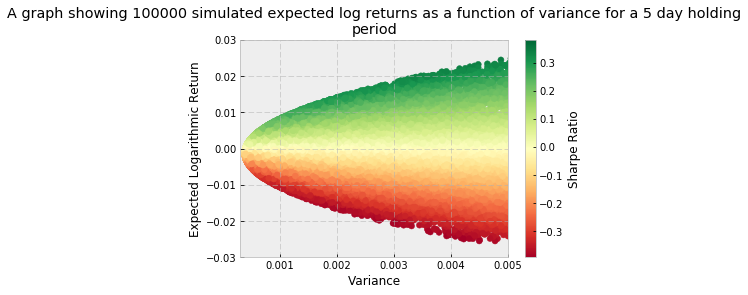

In [37]:
PlotSharpePortfolioSimulations()

The optimal Sharpe portfolio can be analytically deduced by solving the problem:

$\displaystyle{\max_{\boldsymbol{x}} \frac{\boldsymbol{x^T\mu} - r_f}{(\boldsymbol{x^T\Sigma x})^{\frac{1}{2}}}}$   $\quad$ subject to     $\quad$ $\boldsymbol{x^T1}=1$.

By using Lagrangian multipliers again, one can show that the optimal allocation is:

$\boldsymbol{x} = \frac{\boldsymbol{\Sigma^{-1}}(\boldsymbol{\mu} - r_f\boldsymbol{1})}{\boldsymbol{1^T}\boldsymbol{\Sigma^{-1}}(\boldsymbol{\mu} - r_f\boldsymbol{1})}$

The function PlotOptimalSharpePortfolio() below computes the allocation for this optimal portfolio and visualises its location in risk-return space. It does indeed appear to lie near the optimal boundary in an area of high Sharpe ratio portfolios. One can analytically show that this optimal Sharpe portfolio actually lies on the efficient frontier.

In [91]:
def OptimalSharpe(risk_free_rate, mu, sigma):
    
    n = len(mu)
    risk_free_vector = np.matrix( risk_free_rate*np.ones((n, 1)) )
    sigma_inv = np.linalg.inv(sigma)
    
    excess_returns_vector = mu - risk_free_vector
    numerator = sigma_inv * excess_returns_vector
    
    optimal_x = numerator / abs(numerator.sum())
    optimal_mean = (optimal_x.T * mu).tolist()[0][0]
    optimal_variance = (optimal_x.T * sigma * optimal_x).tolist()[0][0]
    optimal_sharpe = (optimal_mean - risk_free_rate) / np.sqrt(optimal_variance)
    
    return [optimal_x, optimal_mean, optimal_variance, optimal_sharpe]

def PlotOptimalSharpePortfolio():
    
    num_simulations = 100000
    risk_free_rate = 0.02
    total_trading_days = 252
    deannualising_exponent = 5 / total_trading_days
    deannualised_risk_free_rate = math.pow(risk_free_rate + 1, deannualising_exponent) - 1
    returns = []
    variances = []
    sharpes = []
    
    returns_data = portfolio_returns( four_symbols )
    mu = np.matrix( returns_data.mean() ).T
    sigma = np.matrix( returns_data.cov() )
    
    for i in range(num_simulations):
        
        ret, variance = RandomPortfolio(mu, sigma)
    
        returns.append( ret )
        variances.append( variance )
        sharpes.append( (ret - deannualised_risk_free_rate) / np.sqrt(variance) )
        
    optimal_x, optimal_mean, optimal_var, optimal_sharpe = OptimalSharpe(deannualised_risk_free_rate, mu, sigma)
    
    plt.style.use(['bmh'])
    fig, ax = plt.subplots(1)
    
    ax.set_title("\n".join(wrap("A graph showing {} simulated expected log returns as a function of variance for a 5 day holding period".format(num_simulations), 100)))
    ax.set_xlabel('Variance')
    ax.set_ylabel('Expected Logarithmic Return')
    ax.set_xlim([0,0.015])
    ax.set_ylim([-0.04,0.04])
    plt.scatter(variances, returns, c=sharpes, marker='o', cmap='RdYlGn')
    plt.plot(optimal_var, optimal_mean, marker="*", color="r", markersize=15)
    cbar = plt.colorbar()
    cbar.set_label("Sharpe Ratio")
    plt.show()
        
    string_1 = "The optimal Sharpe portfolio allocation is {}: {:.2f}, {}: {:.2f}, {}: {:.2f}, {}: {:.2f}\n".format(
                four_symbols[0], -optimal_x.tolist()[0][0], four_symbols[1], -optimal_x.tolist()[1][0], 
                four_symbols[2], -optimal_x.tolist()[2][0], four_symbols[3], -optimal_x.tolist()[3][0])
    
    string_2 = "Producing a portfolio with 5-day statistics:\n\n risk-free rate: {:.4f} \n".format(
                deannualised_risk_free_rate)
    
    string_3 = " expected log returns: {:.4f} \n variance: {:.4f} \n Sharpe ratio: {:.4f}".format(
                optimal_mean, optimal_var, optimal_sharpe)
        
    print(string_1)
    print(string_2 + string_3)

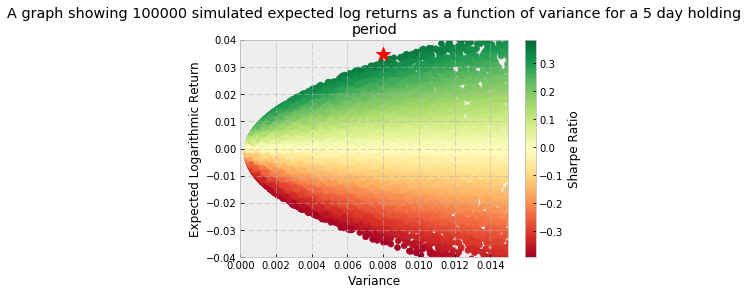

The optimal Sharpe portfolio allocation is AAPL: -0.29, IBM: -2.34, MSFT: 4.94, WMT: -1.30

Producing a portfolio with 5-day statistics:

 risk-free rate: 0.0004 
 expected log returns: 0.0347 
 variance: 0.0080 
 Sharpe ratio: 0.3848


In [92]:
PlotOptimalSharpePortfolio()

## Model Limitations

In estimating the mean vector and covariance matrix the usual time-series trade-off has arisen: robust statistical estimates using a longer lookback period Vs relevant statistical estimates using a shorter lookback period. Different disciplines handle this trade-off in different ways, depending on how stationary one believes the underlying data-generating processes are.

There is lots of research illustrating how sensitive the optimal allocation is to errors in the estimates of these two parameters - particularly the mean vector. This can result in a computed optimal solution that is actually very far from the true optimal solution. In addition, portfolio weights that fluctuate substantially with each rebalancing are undesirable in practise; portfolio managers dislike drastic changes in portfolio composition. There have been several attempts to produce robust formulations that result in more stable solutions. One method is to accept that there will be estimation errors and so allow $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ to exist within *uncertainty sets* [[3](https://www.researchgate.net/publication/220442829_Robust_Portfolio_Selection_Problems)]. Another is to replace mean and covariance with metrics that are less sensitive to outliers (for example median and mean absolute deviation) [[4](http://faculty.london.edu/avmiguel/DeMiguel-Nogales-OR.pdf)]. These often complicate the optimisation by adding extra constraints and so analytical solutions might not always be possible.

Other work has focussed on estimating these parameters better. One can use *shrinkage estimators* for $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ that simultaneously better estimate their true values and produce more robust solutions [[5](http://perso.ens-lyon.fr/patrick.flandrin/LedoitWolf_JMA2004.pdf)]. Otherwise, this leaves the procedure unchanged. The mean is often so hard to estimate that many practitioners simply select the minimum variance portfolio, at the appex of the efficient frontier.

Note that our optimal allocation above involved shorting some of the assets. Many funds are long-only and so this would not be a suitable solution. Markowitz himself created an algorithm to deduce the exact solution in the presence of a no-shorting constraint: $\boldsymbol{x}\geq\boldsymbol{0}$ [[6](https://www.rand.org/content/dam/rand/pubs/research_memoranda/2009/RM1438.pdf)]. Another extension from Black & Litterman uses Bayes' Theorem to update a market estimate of $\boldsymbol{\mu}$ (the prior distribution) with subjective views to determine a new mean vector estimate (the posterior distribution) [[7](https://faculty.fuqua.duke.edu/~charvey/Teaching/BA453_2006/Black_Litterman_GAA_1991.pdf)]. Otherwise, the above procedure is left unchanged. Whilst both of these methods add new features to the original formulation, they also tend to produce more robust solutions.

In the analysis above we analytically determined optimal solutions. In practise numerical optimisation schemes are often used since the errors that they introduce are insignificant when compared to those caused by parameter estimation difficulties. Either method can become very computationally intensive when the whole universe of $n$ assets are considered. The analytical solutions require the inversion an $n\times n$ covariance matrix whilst the numerical schemes have to search an $n$-dimensional vector space. Quantum computers have been used to solve large problems [[8](https://everythingquantum.files.wordpress.com/2018/09/portfolio-optimisation-with-aqc-a-kondratyev-london-qc-meetup-september-2018-final.pdf)].

More fundamental critisms of the classical approach above focus on how well variance can be used as a measure of risk. Whilst variance is a good measure of dispersion for Normal distributions, it fails to capture large deviations from the mean that typify heavy-tailed distributions. It has long been argued that market returns best fit such distributions, wherein variance might not even exist [[9](https://web.williams.edu/Mathematics/sjmiller/public_html/341Fa09/econ/Mandelbroit_VariationCertainSpeculativePrices.pdf)]. Variance is also a symmetric measure, in that it equally penalises desirable deviations above the mean and undesirable deviations below the mean. For example, consider the two following distributions of portfolio returns:

* Returns: 10% [0.5], 20% [0.5]

* Returns: 10% [0.5], 100% [0.5]

The second portfolio is intuitively more desirable, yet it is perceived as riskier since its variance is larger and subsequently has a smaller Sharpe ratio. Markowitz himself recognised this issue and suggested using the asymmetric semi-variance as a measure for downside risk. Recent work has focussed on mean-VaR and mean-cVaR portfolio allocation, with the latter being simplest to optimise [[10](https://pdfs.semanticscholar.org/a5df/128eed59668b525a743a4e7f3f0efe12f930.pdf)].

Interestingly, I first encountered the mathematical analysis above in the context of *beamforming*: a signal processing technique that aims to combine the inputs from an array of sensors in order to receive a signal from a desired direction. This methodology is used in everything from submarine SONAR arrays to Amazon Echo. Here the price time-series of each asset becomes the received signal from each sensor. The portfolio allocation represents the weight one should apply to each sensor and the Sharpe ratio is now a measure of Signal-to-Noise. Many of the stability and estimation issues mentioned above been ameliorated in simliar ways [[11](http://www.sal.ufl.edu/eel6537/2006/rcb2.pdf)].

The latest portfolio optimisation technique is called Hierarchical Risk Parity (HRP) [[12](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678)]. HRP claims that the classical approach is so unstable because it considers any two assets to be indistinguishable. This freedom can cause small estimation errors to radically change the optimal solution. The HRP algorithm first produces a hierarchical tree - clustering assets with similar properties. This tree is then used to re-order the covariance matrix into a quasi-diagonalised form. Lastly the portfolio variance is recursively minimised without having to invert the covariance matrix. This technique appears to produce more stable results and claims to achieve better out-of-sample performance.

## Capital Asset Pricing Model (CAPM)

Markowitz and Sharpe followed their work on optimal portfolio allocation to its natural conclusion. If every investor was privy to the same information and able to invest in every asset then, after computing their rational maximum Sharpe allocation, they would all end up holding the same portfolio. It can be shown that the weight attributed to each asset is positive and simply equal to its market capitalisation as a fraction of the entire market. This portfolio is called the *market portfolio*. In equilibrium, the market massively simplifies our calculations and performs the optimisation itself. This concept gave rise to *index-funds*; these are passive portfolios that hold shares in exactly the same proportion as the market overall.

Using this idea one can easily find a relation between the expected return of any single asset, $\mu_j$, in terms of the expected market return, $\mu_m$

$\mu_j - r_f = \frac{\sigma_{i,m}}{\sigma^2_m}(\mu_m - r_f) = \beta_i(\mu_m - r_f)$

where $r_f$ is the risk-free rate. This is called the Capital Asset Pricing Model (CAPM). $\beta_j$ is a measure of correlation between asset and market returns. It can be positive or negative and indicates how reactive the asset is to the market as a whole. If $\beta_j > 1$ then the asset is more risky than the market: if the market swings up by 1%, the asset might swing up by 2%. This is good if the market is moving up, but not so good if it is moving down. To compensate for this extra risk, the formula above predicts higher returns in excess of the risk-free rate. If $\beta_j < 1$ then the asset is less risky than the market.

The model looks very similar to a linear regression with an intercept, $\alpha_j$, of zero. If such a regression is performed and $\alpha_j \neq 0$ it suggests that the asset consistently under or over performs the market. Some portfolio managers believe that they can pick such assets. CAPM suggests that only $\beta_j$ can be used to outperform the market: by selecting assets with $\beta_j > 1$ when the market is rising and assets with $\beta_j < 1$ when the market is falling (better yet $\beta_j < 0$).

The risk of an asset can be decomposed into a *systematic* part: the tendency for the asset to vary with the market (measured by $\beta$) and an *unsystematic* part: the remaining variability that is attributed to the asset alone, for example caused by an employee strike. CAPM suggests that returns are solely a function of systematic risk, since unsystematic risk can be diversified away.

Later Fama & French created the Three-Factor Model. This included the $\beta$ factor identified by CAPM but also two others that they believed hinted at above-market returns: size (small companies tend to outperform large ones) and value (companies with high P/B ratio tend to outperform those with a low P/B ratio). Later many other factors were identified, giving rise to *factor investing*.